Load the Map

/tmp/ipykernel_4739/3324423449.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_4739/3324423449.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


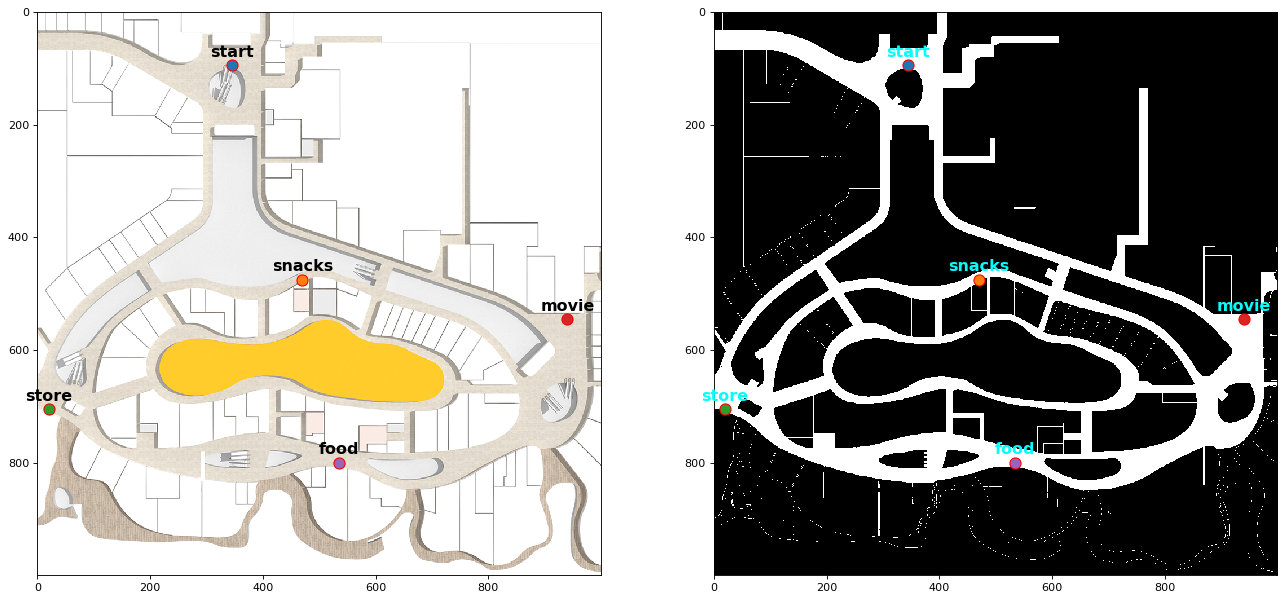

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
import heapq
%matplotlib inline
from tabulate import tabulate
import itertools
import os

floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Global Planning with A* or Dijkstra

In [3]:
def heuristic_cost(node, goal_node, Astar, heuristic_func):
  """
  Calculate heuristic cost between current node and goal node.

  Parameters:
  - node (tuple): The current node coordinates (x, y).
  - goal_node (tuple): The goal node coordinates (x, y).
  - Astar (bool): A flag indicating whether A* algorithm is used.
  - heuristic_func (str): The chosen heuristic function ("Manhattan" or "Euclidean").

  Returns:
  - float: The calculated heuristic cost.
  """
  if not Astar:
    return 0

  if heuristic_func == "Manhattan":
    return abs(node[0] - goal_node[0]) + abs(node[1] - goal_node[1])
  elif heuristic_func == "Euclidean":
    return (np.linalg.norm(np.array(node) - np.array(goal_node)))
  else:
    raise ValueError("Invalid heuristic function. Available options are 'Manhattan' and 'Euclidean'.")

def is_position_valid(node, grid_map):
  """
  Check if a given position is valid within the grid map.

  Parameters:
  - node (tuple): The node coordinates (x, y).
  - grid_map (array): The grid map representing the environment.

  Returns:
  - bool: True if the position is valid, False otherwise.
  """
  lower_bound = (0, 0)
  upper_bound = (grid_map.shape[0], grid_map.shape[1])

  within_bounds = (node >= lower_bound) & (node < upper_bound)

  # Return True if all coordinates of the node are within bounds, False otherwise
  return np.all(within_bounds)

def is_cell_occupied(node, grid_map):
  """
  Check if a cell in the grid map is occupied.

  Parameters:
  - node (tuple): The cell coordinates (x, y).
  - grid_map (array): The grid map representing the environment.

  Returns:
  - bool: True if the cell is occupied, False otherwise.
    """
  return grid_map[node[0], node[1]] != 255

def is_space_available(node, grid_map):
  """
  Check if there is space available around the robot's footprint.

  Parameters:
  - node (tuple): The node coordinates (x, y).
  - grid_map (array): The grid map representing the environment.

  Returns:
  - bool: True if space is available, False otherwise.
    """
  nearest_points = [[0, 3], [-3, 0], [3, 0], [0, -3]]  # Considers 4 neighboring points at a distance of 3 units
  for point in nearest_points:
    neighbour_point = (node[0] + point[0], node[1] + point[1])
    if not is_position_valid(neighbour_point, grid_map) or is_cell_occupied(neighbour_point, grid_map):
      return False
  return True


def planning(grid_map, resolution, start, goal, Astar, heuristic_func):
  """
  Plan a path from start to goal on the grid map using A* or Dijkstra's algorithm.

  Parameters:
  - grid_map (array): The grid map representing the environment.
  - resolution (float): The resolution of the grid map.
  - start (tuple): The start coordinates (x, y) of the path.
  - goal (tuple): The goal coordinates (x, y) of the path.
  - Astar (bool): A flag indicating whether to use A* algorithm (True) or Dijkstra's algorithm (False).
  - heuristic_func (function): The heuristic function to be used if A* algorithm is chosen.

  Returns:
  - path (list of tuples): The path from start to goal.
  - visited_grid (set of tuples): The set of visited grid coordinates during pathfinding.
  - distance (float): The total distance traveled along the path.
  """

  start_node = tuple(start)
  goal_node = tuple(goal)

  path = []
  open_set = []
  closed_set = set()
  parents = {}

  g_scores = {start_node: 0}
  f_scores = {start_node: heuristic_cost(start_node, goal_node, Astar, heuristic_func)}

  if Astar:
    heapq.heappush(open_set, (f_scores[start_node], start_node))
  else:
    heapq.heappush(open_set, (g_scores[start_node], start_node))

  neighbours = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, -1), (-1, 1), (1, -1)]

  while open_set:
    current_node_f_score, current_node = heapq.heappop(open_set)

    if current_node in closed_set:
      continue
    if current_node == goal_node:
      break  # Terminate the search if the goal node is found

    closed_set.add(current_node)

    for dx, dy in neighbours:
      neighbour = (current_node[0] + dx, current_node[1] + dy)

      if (is_position_valid(neighbour, grid_map)
          and not is_cell_occupied(neighbour, grid_map) and is_space_available(neighbour, grid_map) and
          neighbour not in closed_set):

        neighbor_g_score = g_scores[current_node] + np.linalg.norm(np.array(neighbour) - np.array(current_node))
        if neighbour not in g_scores or neighbor_g_score < g_scores[neighbour]:
          parents[neighbour]  = current_node
          g_scores[neighbour] = neighbor_g_score
          f_scores[neighbour] = g_scores[neighbour] + heuristic_cost(neighbour, goal_node, Astar, heuristic_func)
          heapq.heappush(open_set, (f_scores[neighbour], neighbour))  # Push tuple to the priority queue

  distance_travelled = g_scores.get(goal_node, np.inf) * resolution

  if goal_node in parents:
      node = goal_node
      while node != start_node:
          path.append(node)
          node = parents[node]
      path.append(start_node)
      path.reverse()
      return path, closed_set, distance_travelled

  print("No path found")
  return [], [], None

In [4]:
# Helper Functions
def plot_map(visited_grids, path, directory=None, file_name=None):
  """
  Plot the grid map with visited grids and path trajectory.

  Parameters:
  - visited_grids (list of tuples): List of coordinates representing visited grids.
  - path (list of tuples): List of coordinates representing the path trajectory.
  - directory (str): Optional directory path for saving the plot.
  - file_name (str): Optional file name for saving the plot.
  """
  # Create directory if specified and doesn't exist
  if directory and not os.path.exists(directory):
    os.makedirs(directory)

  # Display the grid map image
  plt.figure(figsize=(8, 8))
  plt.imshow(grid_map_img, cmap='gray')

  # Plot locations
  plot_locations(locations, color='cyan')

  # Plot visited grids
  visited_xs, visited_ys = zip(*visited_grids)
  plt.scatter(visited_xs, visited_ys, color='orange', marker='o', label='Visited Grids')

  # Plot the trajectory
  path_xs, path_ys = zip(*path)
  plt.plot(path_xs, path_ys, color='blue', linewidth=2, label='Trajectory')

  plt.legend()
  # Save plot to file if specified
  if file_name:
    if directory:
      file_path = os.path.join(directory, file_name)
    else:
      file_path = file_name
    plt.savefig(file_path)
    plt.close()
  else:
    plt.show()

def tabulate_data(data, title):
  """
  Tabulate the provided data.

  Parameters:
  - data (dict): A dictionary containing data values.
  - title (str): The title for the data set.
  """
  # Initialize the table data
  table_data = []

  # Iterate over each pair of locations and append the distance to the table data
  for start_location in locations:
      row = [start_location]
      for dest_location in locations:
          if start_location == dest_location:
              row.append(0)  # Distance from a location to itself is 0
          else:
              row.append(data.get((start_location, dest_location), 'N/A'))
      table_data.append(row)

  # Define the headers for the table
  headers = ["From/To"] + list(locations.keys())

  # Print the table
  print(title)
  print(tabulate(table_data, headers=headers, floatfmt=".4f"))
  print()

def get_statistics(data, title):
  """
  Calculate and print statistics for the provided data.

  Parameters:
  - data (dict): A dictionary containing data values.
  - title (str): The title for the data set.
  """
  if not data:
    print(f"No data available for {title}")
    return

  min_val = min(data.values())
  max_val = max(data.values())
  avg = sum(data.values()) / len(data)

  print(f"{title}: Min={min_val:.2f}, Max={max_val:.2f}, Avg={avg:.2f}\n")

def get_results(grid_map, resolution, Astar, heuristic_func, display):
  """
  Calculate paths, visited grids, distances, and runtimes between all pairs of landmarks.
  Parameters:
  - grid_map (array): The grid map representing the environment.
  - resolution (float): The resolution of the grid map.
  - Astar (bool): A flag indicating whether to use A* algorithm or Dijkstra's algorithm.
  - heuristic_func (function): The heuristic function to be used if A* algorithm is chosen.
  - display (bool): A flag indicating whether to display results.

  Returns:
  - paths (dict): A dictionary containing paths between all pairs of landmarks.
  - visited_grids (dict): A dictionary containing the number of visited grids for each path.
  - distances (dict): A dictionary containing distances traveled for each path.
  - runtimes (dict): A dictionary containing runtimes for each operation.
  """
  paths         = {}
  visited_grids = {}
  distances     = {}
  runtimes      = {}

  for i, start_landmark in enumerate(list(locations.keys())):
    for j, dest_landmark in enumerate(list(locations.keys())):
      if i != j:  # Ensure the start and destination landmarks are different
        start_node = locations[start_landmark]
        goal_node = locations[dest_landmark]
        start_time = time.time()
        path, visited_grid, distance = planning(grid_map, resolution,
                                                  start_node, goal_node,
                                                  Astar, heuristic_func)
        end_time = time.time()
        runtime  = end_time - start_time
        paths[(start_landmark, dest_landmark)]         = path
        visited_grids[(start_landmark, dest_landmark)] = len(visited_grid)
        distances[(start_landmark, dest_landmark)]     = distance
        runtimes[(start_landmark, dest_landmark)]      = runtime

        directory = f"Astar_{heuristic_func}" if Astar else "Dijkstra"
        file_name = f"{start_landmark}_to_{dest_landmark}"
        if display:
          print(f"{directory}: {file_name}")
          print("Total Traveled Distance (m):", distance)
          print("Visited Cells:", len(visited_grid))
          print("Runtime (s):", runtime)
          directory, file_name = None, None

        plot_map(visited_grid, path, directory, file_name)

  return paths, visited_grids, distances, runtimes

In [5]:
# Get the path, visited grids, runtime for all the combinations for A* with Manhattan
Astar_manh_path, Astar_manh_grids, Astar_manh_dist, Astar_manh_runtimes = get_results(grid_map, resolution=MAP_RES, Astar=True, heuristic_func="Manhattan", display=False)


In [8]:
print("Tabulate Results for Astar with Manhattan Heuristic Function")
tabulate_data(Astar_manh_dist, "Distances")

tabulate_data(Astar_manh_grids, "Visited Grids")
get_statistics(Astar_manh_grids, "Visited Grid")

tabulate_data(Astar_manh_runtimes, "Runtimes")
get_statistics(Astar_manh_runtimes, "Runtimes")

Tabulate Results for Astar with Manhattan Heuristic Function
Distances
From/To       start    snacks     store     movie      food
---------  --------  --------  --------  --------  --------
start        0.0000  143.9484  155.4847  179.1249  225.9180
snacks     143.9484    0.0000  119.7235  108.7377  140.0999
store      158.0871  115.6916    0.0000  210.8597  111.5328
movie      179.1249  108.7377  210.8597    0.0000  114.4264
food       225.9180  140.0999  111.5328  114.4264    0.0000

Visited Grids
From/To      start    snacks    store    movie    food
---------  -------  --------  -------  -------  ------
start            0     27934     2364     1645   48050
snacks        9637         0     2763     6262   14077
store         7010      2121        0    33458    6544
movie         1888      5616    16706        0    1365
food         36159     22705     6595     1891       0

Visited Grid: Min=1365.00, Max=48050.00, Avg=12739.50

Runtimes
From/To      start    snacks    store    mov

In [7]:
# Get the path, visited grids, runtime for all the combinations for A* with Euclidean
Astar_eucl_path, Astar_eucl_grids, Astar_eucl_dist, Astar_eucl_runtimes  = get_results(grid_map, resolution=MAP_RES, Astar=True, heuristic_func="Euclidean", display=False)

In [9]:
print("Tabulate Results for Astar with Euclidean Heuristic Function")
tabulate_data(Astar_eucl_dist, "Distances")

tabulate_data(Astar_eucl_grids, "Visited Grids")
get_statistics(Astar_eucl_grids, "Visited Grid")

tabulate_data(Astar_eucl_runtimes, "Runtimes")
get_statistics(Astar_eucl_runtimes, "Runtimes")

Tabulate Results for Astar with Euclidean Heuristic Function
Distances
From/To       start    snacks     store     movie      food
---------  --------  --------  --------  --------  --------
start        0.0000  143.9484  155.4847  179.1249  225.8008
snacks     143.9484    0.0000  115.6916  108.7377  140.0999
store      155.4847  115.6916    0.0000  210.8597  111.5328
movie      179.1249  108.7377  210.8597    0.0000  113.6063
food       225.8008  140.0999  111.5328  113.6063    0.0000

Visited Grids
From/To      start    snacks    store    movie    food
---------  -------  --------  -------  -------  ------
start            0     32024    26585    27123   68197
snacks       20958         0    12869     9641   24109
store        23220     21527        0    56589   16994
movie        20750     10555    36248        0   23901
food         58966     32985    19210    22874       0

Visited Grid: Min=9641.00, Max=68197.00, Avg=28266.25

Runtimes
From/To      start    snacks    store    mov

In [10]:
# Get the path, visited grids, runtime for all the combinations for Dijkstra
Dijkstra_path, Dijkstra_grids, Dijkstra_dist, Dijkstra_runtimes = get_results(grid_map, resolution=MAP_RES, Astar=False, heuristic_func=None, display=False)

In [11]:
print("Tabulate Results for Dijkstra")
tabulate_data(Dijkstra_dist, "Distances")

tabulate_data(Dijkstra_grids, "Visited Grids")
get_statistics(Dijkstra_grids, "Visited Grid")

tabulate_data(Dijkstra_runtimes, "Runtimes")
get_statistics(Dijkstra_runtimes, "Runtimes")

Tabulate Results for Dijkstra
Distances
From/To       start    snacks     store     movie      food
---------  --------  --------  --------  --------  --------
start        0.0000  143.9484  155.4847  179.1249  225.8008
snacks     143.9484    0.0000  115.6916  108.7377  140.0999
store      155.4847  115.6916    0.0000  210.8597  111.5328
movie      179.1249  108.7377  210.8597    0.0000  113.6063
food       225.8008  140.0999  111.5328  113.6063    0.0000

Visited Grids
From/To      start    snacks    store    movie    food
---------  -------  --------  -------  -------  ------
start            0     60082    69890    82956  126295
snacks      102234         0    66437    53890   97020
store        77152     50008        0   125836   48788
movie        92818     47861   121680        0   49487
food        115037     84945    64301    66653       0

Visited Grid: Min=47861.00, Max=126295.00, Avg=80168.50

Runtimes
From/To      start    snacks    store    movie     food
---------  ------

## Task 2

Distance from Astar Manhanttan
Optimal Route: ('start', 'store', 'food', 'movie', 'snacks', 'start')
Total Distance: 634.1300141024125


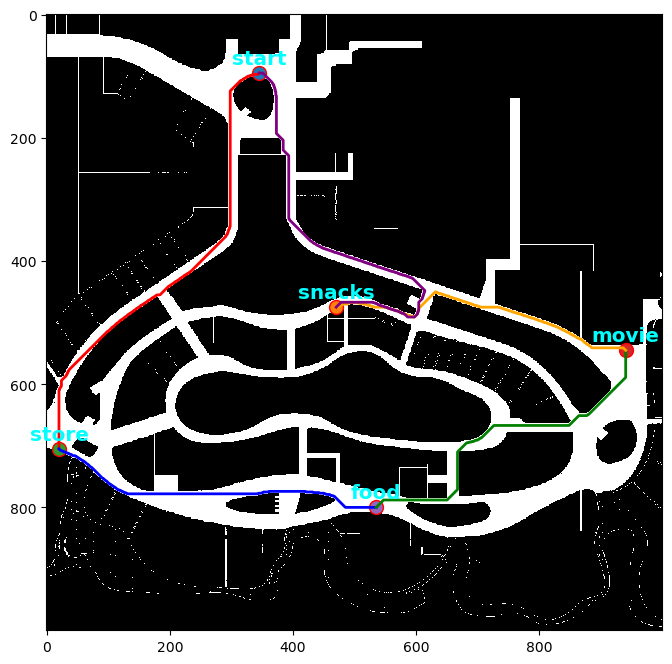

Distance from Astar Euclidean
Optimal Route: ('start', 'snacks', 'movie', 'food', 'store', 'start')
Total Distance: 633.3099130897348


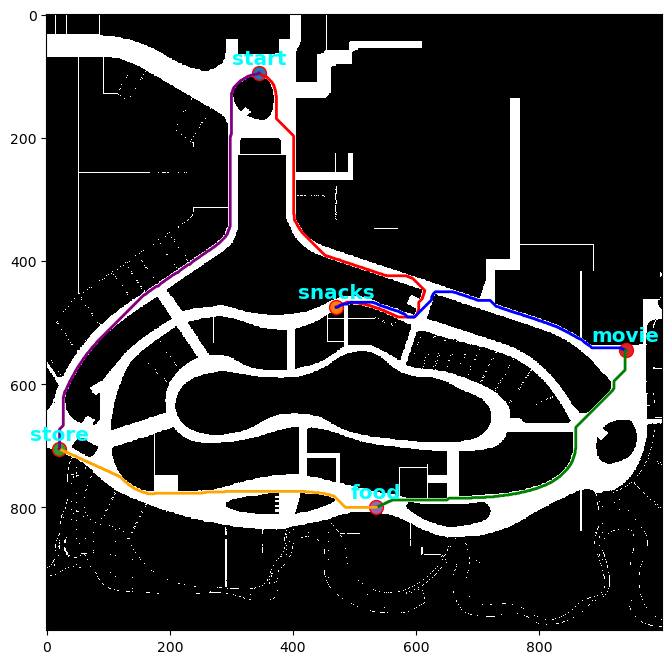

Distance from Dijkstra
Optimal Route: ('start', 'snacks', 'movie', 'food', 'store', 'start')
Total Distance: 633.3099130897348


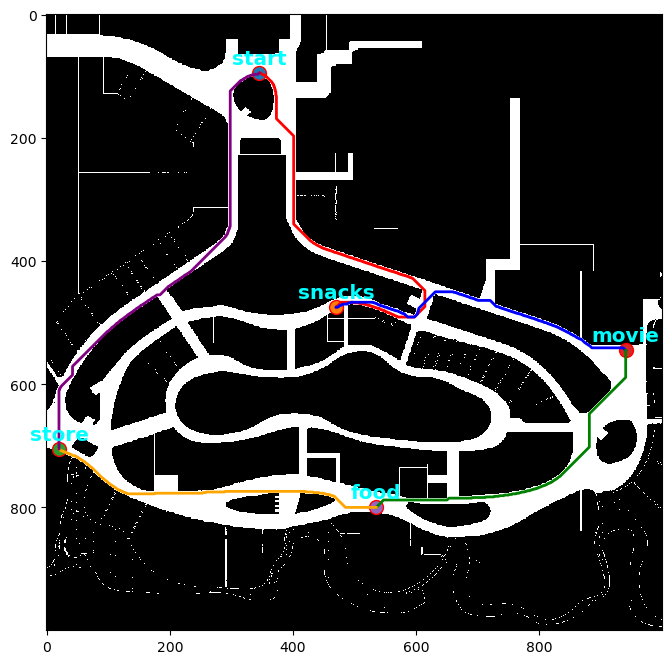

In [12]:
def calculate_total_distance(distances, route):
  """
  Calculate the total distance of a given route using brute force method.

  Parameters:
  - distances (dict): A dictionary containing distances between locations.
  - route (list): A list representing the route sequence.

  Returns:
  - int: The total distance traveled along the route.
  """
  total_distance = 0
  for i in range(len(route) - 1):
      total_distance += distances[(route[i], route[i+1])]
  total_distance += distances[(route[-1], route[0])]  # Return to start
  return total_distance

def plot_route(optimal_route, path):
  """
  Plot the optimal route along with the paths.

  Parameters:
  - optimal_route (list): A list representing the optimal route sequence.
  - path (dict): A dictionary containing paths between locations.
  """
  # Display the grid map image
  plt.figure(figsize=(8, 8))
  plt.imshow(grid_map_img, cmap='gray')

  # Plot locations
  plot_locations(locations, color='cyan')

  colors = ['red','blue','green','orange','purple']
  for i in range(len(optimal_route) - 1):
    start_end = (optimal_route[i], optimal_route[i+1])
    sub_path = path[start_end]
    # Plot the trajectory
    path_xs, path_ys = zip(*sub_path)
    plt.plot(path_xs, path_ys, color=colors[i], linewidth=2, label='Path')

  plt.show()

def brute_force(distances):
  """
  Find the optimal route using brute force method.

  Parameters:
  - distances (dict): A dictionary containing distances between locations.

  Returns:
  - tuple: A tuple containing the optimal route sequence and its total distance.
  """
  # Generate all possible routes
  locations_list = list(locations.keys())
  routes = itertools.permutations(locations_list[1:])  # Exclude 'start' as we start and end at the same location

  optimal_route = None
  min_distance = float('inf')
  for route in routes:
      total_distance = calculate_total_distance(distances, ('start',) + route)
      if total_distance < min_distance:
          min_distance = total_distance
          optimal_route = ('start',) + route
  optimal_route += ('start',)

  return optimal_route, min_distance


list_of_algorithms = [(Astar_manh_path, Astar_manh_dist, "Astar Manhanttan"), (Astar_eucl_path, Astar_eucl_dist, "Astar Euclidean"), (Dijkstra_path, Dijkstra_dist, "Dijkstra")]

for path, dist, planning_algo in list_of_algorithms:

  optimal_route, total_distance = brute_force(dist)

  # Print the optimal route and its total distance
  print("Distance from", planning_algo)
  print("Optimal Route:", optimal_route)  # Add start to the beginning and end of the route
  print("Total Distance:", total_distance)
  plot_route(optimal_route, path)


Distance from Astar Manhanttan
Optimal Route: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 636.7324527641763


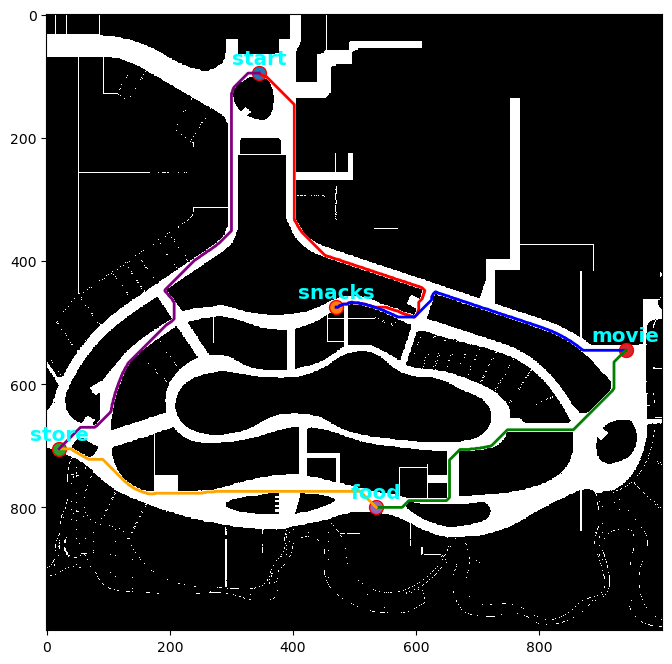

Distance from Astar Euclidean
Optimal Route: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 633.3099130897348


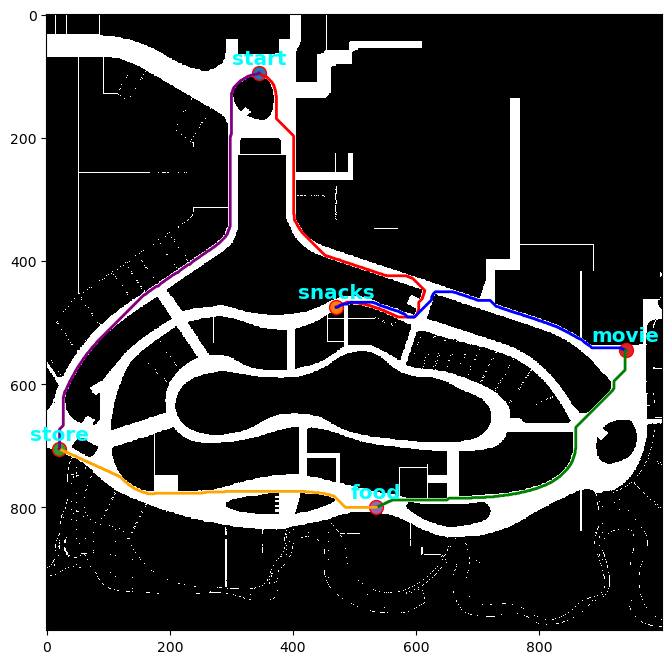

Distance from Dijkstra
Optimal Route: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 633.3099130897348


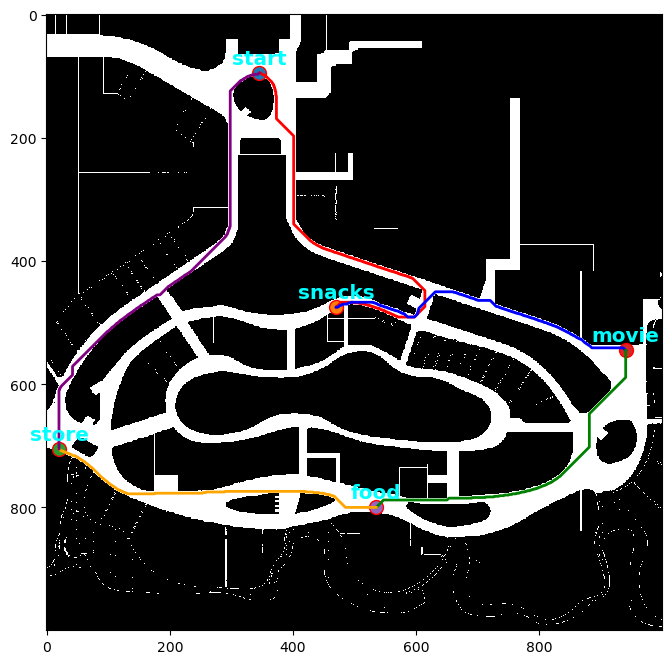

In [14]:
def nearest_neighbour(start, distances):
  """
  Find the optimal route using the nearest neighbour algorithm.

  Parameters:
  - start (str): The starting location.
  - distances (dict): A dictionary containing distances between locations.

  Returns:
  - tuple: A tuple containing the optimal route sequence and its total distance.
  """
  unvisited = set(locations.keys())
  unvisited.remove(start)
  current_location = start
  path = [start]
  total_distance = 0

  while unvisited:
    nearest_neighbour = min(unvisited, key=lambda x: distances[(current_location, x)])
    total_distance += distances[(current_location, nearest_neighbour)]
    path.append(nearest_neighbour)
    unvisited.remove(nearest_neighbour)
    current_location = nearest_neighbour

  # Return to the start location
  total_distance += distances[(path[-1], start)]
  path += ('start',)
  return path, total_distance

start_location = 'start'
list_of_algorithms = [(Astar_manh_path, Astar_manh_dist, "Astar Manhanttan"), (Astar_eucl_path, Astar_eucl_dist, "Astar Euclidean"), (Dijkstra_path, Dijkstra_dist, "Dijkstra")]

for path, dist, planning_algo in list_of_algorithms:
  optimal_route, total_distance = nearest_neighbour(start_location, dist)

  # Print the optimal route and its total distance
  print("Distance from", planning_algo)
  print("Optimal Route:", optimal_route)
  print("Total Distance:", total_distance)
  plot_route(optimal_route, path)


Distance from Astar Manhanttan
Optimal Route: ['start', 'movie', 'food', 'store', 'snacks', 'start']
Total Distance: 664.7241266521078


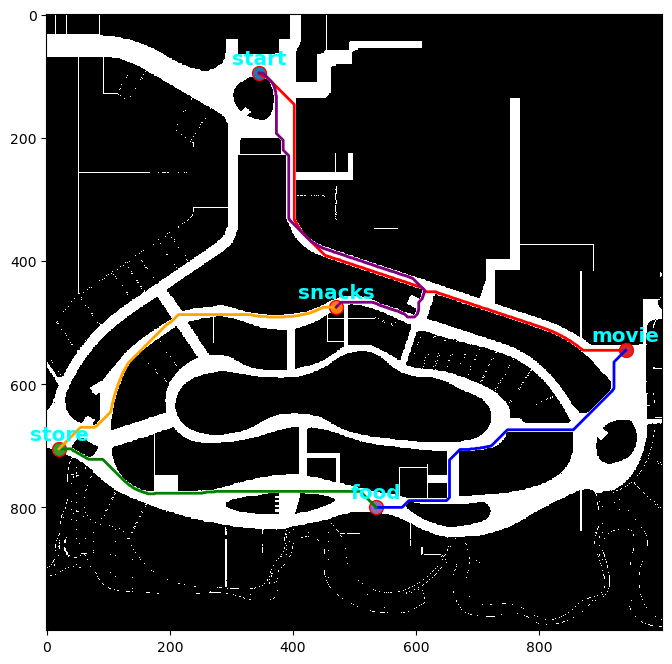

Distance from Astar Euclidean
Optimal Route: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 633.3099130897348


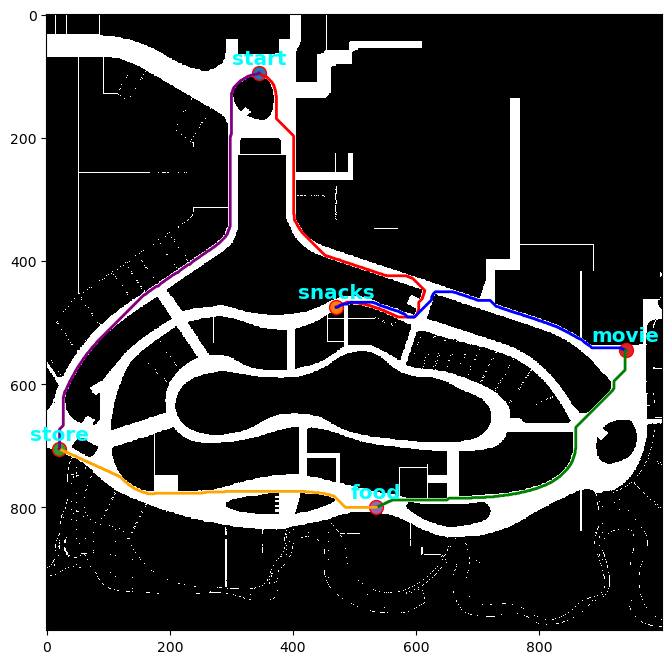

Distance from Dijkstra
Optimal Route: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 633.3099130897348


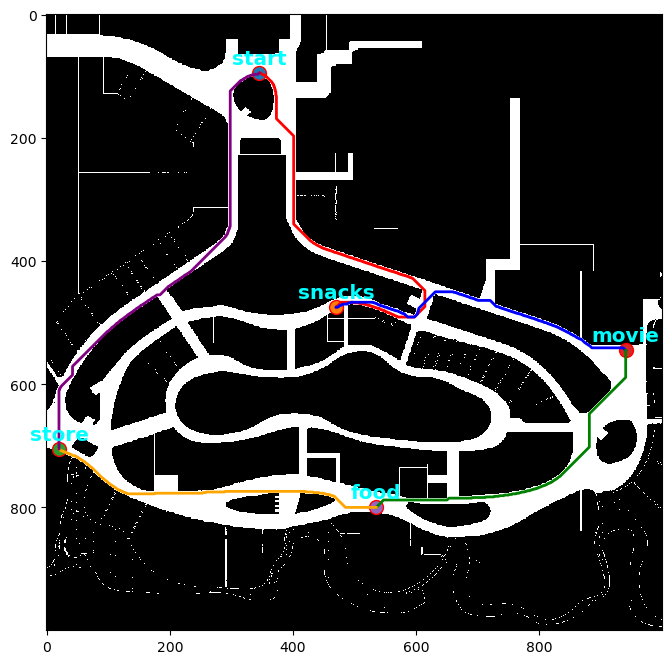

In [15]:
import random
# Genetic Algorithm parameters
POPULATION_SIZE = 100
MUTATION_RATE   = 0.01
NUM_GENERATIONS = 1000

def generate_initial_population(population_size):
  """
  Generate the initial population for the genetic algorithm.

  Parameters:
  - population_size (int): The size of the population.

  Returns:
  - list: A list containing the initial population of routes.
  """
  initial_population = []
  locations_list = list(locations.keys())
  for _ in range(population_size):
    route = random.sample(locations_list[1:], len(locations_list) - 1)  # Excluding 'start'
    initial_population.append(route)
  return initial_population

def crossover(parent1, parent2):
  """
  Perform crossover operation between two parent routes.

  Parameters:
  - parent1 (list): The first parent route.
  - parent2 (list): The second parent route.

  Returns:
  - list: The child route produced by crossover.
  """
  crossover_point = random.randint(1, len(parent1) - 1)
  child = parent1[:crossover_point]
  for gene in parent2:
    if gene not in child:
      child.append(gene)
  return child

def mutate(route):
  """
  Perform mutation operation on a route.

  Parameters:
  - route (list): The route to be mutated.

  Returns:
  - list: The mutated route.
  """
  index1, index2 = random.sample(range(1, len(route)), 2)
  route[index1], route[index2] = route[index2], route[index1]
  return route

# Genetic Algorithm
def genetic_algorithm(population_size, generations, mutation_rate, distance):
  """
  Perform the genetic algorithm to find the optimal route.

  Parameters:
  - population_size (int): The size of the population.
  - generations (int): The number of generations.
  - mutation_rate (float): The mutation rate.
  - distance (dict): A dictionary containing distances between locations.

  Returns:
  - list: The optimal route sequence.
  """
  population = generate_initial_population(population_size)
  for _ in range(generations):
    population = sorted(population, key=lambda x: calculate_total_distance(distance, x))
    new_population = population[:int(0.1 * population_size)]  # Elitism: Keep top 10% of the population
    while len(new_population) < population_size:
      parent1, parent2 = random.sample(population[:int(0.5 * population_size)], 2)  # Select parents
      child = crossover(parent1, parent2)  # Crossover
      if random.random() < mutation_rate:
        child = mutate(child)  # Mutation
      new_population.append(child)
    population = new_population
    optimal_route = sorted(population, key=lambda x: calculate_total_distance(distance, x))[0]
    optimal_route.insert(0, 'start')
  return optimal_route

list_of_algorithms = [(Astar_manh_path, Astar_manh_dist, "Astar Manhanttan"), (Astar_eucl_path, Astar_eucl_dist, "Astar Euclidean"), (Dijkstra_path, Dijkstra_dist, "Dijkstra")]

for path, dist, planning_algo in list_of_algorithms:
  optimal_route = genetic_algorithm(POPULATION_SIZE, NUM_GENERATIONS, MUTATION_RATE, dist)
  total_distance = calculate_total_distance(dist, optimal_route)
  optimal_route += ('start',)
  # Print the optimal route and its total distance
  print("Distance from", planning_algo)
  print("Optimal Route:", optimal_route)  # Add start to the beginning and end of the route
  print("Total Distance:", total_distance)
  plot_route(optimal_route, path)